In [ ]:
#Snn torch Installation 
!pip install snntorch --quiet

     |████████████████████████████████| 92 kB 381 kB/s 


In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import os
import tensorflow as tf
import torch, torch.nn as nn
import snntorch as snn
import glob
from skimage import color
from skimage import io
from google.colab import drive

In [ ]:
#Data Loading
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#Data Loading
image_data_train = []
image_labels_train = []
!ls drive/MyDrive/MyTrafficWorkingDataSet/Data
data_dir = r'drive/MyDrive/MyTrafficWorkingDataSet/Data'
for i in range(2):
    path =os.path.join(data_dir,str(i+1))
    print('Patth: '+path)
    for img in os.listdir(path):
        try:
            
            image = cv2.imread(os.path.join(path,img),0)
            image_fromarray = Image.fromarray(image, 'L')
            
            resize_image = image_fromarray.resize((28,28))
            image_data_train.append(np.array(resize_image))
            image_labels_train.append(i)
        except:
            print("Error in " + img)

#Reshaping the data
image_data_train = np.array(image_data_train)
image_data_train = np.expand_dims(image_data_train, axis=-1)
image_labels_train = np.array(image_labels_train)

print(image_data_train.shape, image_labels_train.shape)

image_data_train = image_data_train.astype(np.float32)
print(image_data_train.dtype)

1  2
Patth: drive/MyDrive/MyTrafficWorkingDataSet/Data/1
Patth: drive/MyDrive/MyTrafficWorkingDataSet/Data/2
(5349, 28, 28, 1) (5349,)
float32


In [ ]:
#Changing the axis
print(image_data_train.shape, image_labels_train.shape)
rearranged_arr_train = np.moveaxis(image_data_train, [3,1,2],[1,2,3])
image_data_train = rearranged_arr_train
print(rearranged_arr_train.shape, image_labels_train[5000])

(5349, 28, 28, 1) (5349,)
(5349, 1, 28, 28) 1


In [ ]:
 if torch.cuda.is_available():
      device = 'cuda'
      print('cuda')
 else:
      device = 'cpu'
      print('cpu')


cuda


In [ ]:
#  Initialize Network

from snntorch import surrogate

beta = 0.9 
spike_grad = surrogate.fast_sigmoid()


net = nn.Sequential(nn.Conv2d(1, 8, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(8, 16, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(16*4*4, 2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
# forward pass
from snntorch import utils 

def forward_pass(net, data, num_steps):  
  spk_rec = []
  utils.reset(net)

  for step in range(num_steps): 
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [ ]:
#optimizer and loss
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
i = 0

Test Images Load


In [ ]:
#Test Image load
image_data_test = []
image_labels_test = []
!ls drive/MyDrive/MyTrafficWorkingTest/Data
data_dir = r'drive/MyDrive/MyTrafficWorkingTest/Data'
for i in range(2):
    path =os.path.join(data_dir,str(i+1))
    print('Patth: '+path)
    for img in os.listdir(path):
        try:
            
            image = cv2.imread(os.path.join(path,img),0)
            image_fromarray = Image.fromarray(image, 'L')
            
            resize_image = image_fromarray.resize((28,28))
            image_data_test.append(np.array(resize_image))
            image_labels_test.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data_test = np.array(image_data_test)
image_data_test = np.expand_dims(image_data_test, axis=-1)
image_labels_test = np.array(image_labels_test)

print(image_data_test.shape, image_labels_test.shape)

image_data_test = image_data_test.astype(np.float32)
print(image_data_test.dtype)

1  2
Patth: drive/MyDrive/MyTrafficWorkingTest/Data/1
Patth: drive/MyDrive/MyTrafficWorkingTest/Data/2
(200, 28, 28, 1) (200,)
float32


In [ ]:
#rearraging the test code
rearranged_arr_test = np.moveaxis(image_data_test, [3,1,2],[1,2,3])
image_data_test = rearranged_arr_test
print(rearranged_arr_test.shape, image_labels_test.shape)

(200, 1, 28, 28) (200,)


In [ ]:
# training and testing code
num_epochs = 30
num_steps = 25  # run for 25 time steps 

loss_hist_train = []
acc_hist_train = []
acc_hist_test = []

for epoch in range(num_epochs):
    data = image_data_train
    targets = image_labels_train
    data = torch.FloatTensor(data) 
    targets = torch.FloatTensor(targets)
    
    data = data.to(device)
    targets = targets.to(device)
       
    net.train()
    spk_rec = forward_pass(net, data, num_steps)
    loss_val = loss_fn(spk_rec, targets)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    loss_hist_train.append(loss_val.item())

    if i % 25 == 0:
      print(f"Epoch {epoch}, \nTrain Loss: {loss_val.item():.2f}")

    acc = SF.accuracy_rate(spk_rec, targets)  
    acc_hist_train.append(acc)
    print(f"Accuracy: {acc * 100:.2f}%\n")


    total = 0
    acc = 0 
    net.eval()
    data_test = image_data_test
    targets_test = image_labels_test
    data_test = torch.FloatTensor(data_test) 
    targets_test = torch.FloatTensor(targets_test)
    
    data_test = data_test.to(device)
    targets_test = targets_test.to(device)

    spk_rec = forward_pass(net, data_test, num_steps)
    acc += SF.accuracy_rate(spk_rec, targets_test) * spk_rec.size(1)
    total += spk_rec.size(1)
    acc_hist_test.append(acc/total)
    print("Test Accuracy ", acc/total)

Accuracy: 25.61%

Test Accuracy  0.5
Accuracy: 25.61%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.62
Accuracy: 76.33%

Test Accuracy  0.835
Accuracy: 85.46%

Test Accuracy  0.775
Accuracy: 82.28%

Test Accuracy  0.55
Accuracy: 75.86%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.5
Accuracy: 74.39%

Test Accuracy  0.51
Accuracy: 74.65%

Test Accuracy  0.545
Accuracy: 76.29%

Test Accuracy  0.74
Accuracy: 82.22%

Test Accuracy  0.87
Accuracy: 90.13%

Test Accuracy  0.93
Accuracy: 94.90%

Test Accuracy  0.95
Accuracy: 95.91%

Test Accuracy  0.955
Accuracy: 96.58%

Test 

In [ ]:
#printing the values
print("Training Accuracy ", acc_hist_train)
print("Testing Accuracy ", acc_hist_test)
print("Loss ", loss_hist_train)

Training Accuracy  [0.2561226397457469, 0.2561226397457469, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7633202467750981, 0.8545522527575248, 0.8227706113292205, 0.7586464759768181, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7438773602542531, 0.7464946719012899, 0.7629463451112357, 0.8222097588334268, 0.9012899607403253, 0.9489624228827819, 0.9590577678070668, 0.96578799775659, 0.9626098336137596, 0.9693400635632828, 0.9740138343615629]
Testing Accuracy  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.62, 0.835, 0.775, 0.55, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.545, 0.74, 0.87, 0.93, 0.95, 0.955, 0.97, 0.97, 0.98, 0.985]
Loss  [7.414608001708984, 3.6718599796295166, 1.8836866617202759, 2.2761785984039307, 2.452768564224243, 2.168726682662964, 1.7775695323944092, 1.5717328786849976, 1.6106823682785034, 1.7577079

In [ ]:
Training_Accuracy = acc_hist_train
Testing_Accuracy = acc_hist_test
Loss = loss_hist_train
len(Loss)

30

In [ ]:
X = []
for i in range(30):
  X.append(i)  

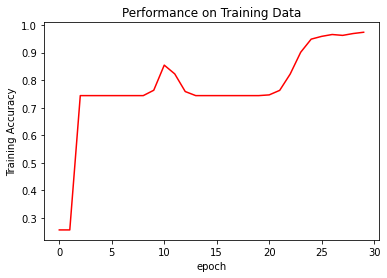

In [ ]:
#graph plotting
plt.plot(X, Training_Accuracy, color='red')
plt.xlabel('epoch')
plt.ylabel('Training Accuracy')
plt.title('Performance on Training Data')
plt.savefig('Train.jpeg')
plt.show()

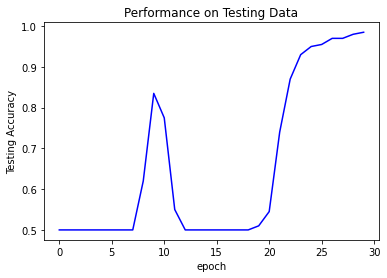

In [ ]:
plt.plot(X, Testing_Accuracy, color='blue')
plt.xlabel('epoch')
plt.ylabel('Testing Accuracy')
plt.title('Performance on Testing Data')
plt.savefig('Test.jpeg')
plt.show()

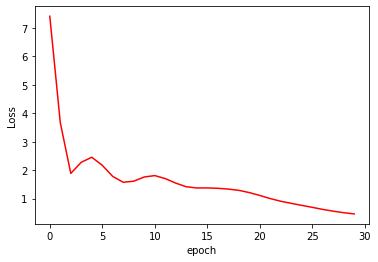

In [ ]:
plt.plot(X, Loss, color='red')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('loss.jpeg')
plt.show()